# Driver Drowsiness Detection using CNN

## Introduction

This Notebook demonstrates the application of a Convolutional Neural Network (CNN) for the purpose of driver drowsiness detection. 
The notebook is structured as follows:
1. Data Loading and Preprocessing
2. Model Building
3. Model Training and Evaluation
4. Results Analysis and Visualization
5. Conclusion

## Data Loading and Preprocessing

### Imports

In [170]:
# Import necessary libraries and modules
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

from PIL import Image

import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import re
import os
import numpy as np
import re

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split



import matplotlib.pyplot as plt

import math

In [171]:

if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


### Dataframe creation from Dataset

In [172]:
# Initialize lists to store image paths, labels, file names, and person IDs
image_path, label, file_name, person_ID = [], [], [], []

# Compile a regex pattern to identify the person ID from the file name
pattern = re.compile(r'^[a-zA-Z][a-zA-Z]?')

# Get the current working directory and construct the data directory path
path = os.getcwd()
data_dir = os.path.join(path, 'Driver Drowsiness Dataset (DDD)')

# Iterate over each class (folder) in the dataset directory
for class_name in os.listdir(data_dir):
    # Iterate over each image file in the class folder
    for file_path in os.listdir(os.path.join(data_dir, class_name)):
        # Assign label based on class name
        label.append(0 if class_name == 'Drowsy' else 1)
        # Construct and store the full path of the image
        image_path.append(os.path.join(data_dir, class_name, file_path))
        # Store the file name
        file_name.append(file_path)
        # Extract and store the person ID from the file name
        person_ID.append(pattern.findall(file_path)[0])

# Create a DataFrame with image paths, labels, file names, and person IDs
df = pd.DataFrame({'images': image_path, 'label': label, 'name': file_name, 'person': person_ID})

print('DataFrame df')
print(df.shape)

# Split the DataFrame into test set with specific persons and the rest
# Add Person E and G only to the Test Dataset
dfTest = pd.concat([df[df['person'] == person] for person in ['o', 'O', 'p', 'P', 'zb', 'ZB']])

print('DataFrame dfTest')
print(dfTest.shape)

# Remove specified persons from the dataset
dfWithout = df.drop(df[df['person'].isin(['o', 'O', 'p', 'P', 'zb', 'ZB'])].index)

print('DataFrame dfWithout')
print(dfWithout.shape)

# Convert image paths and labels of the test set into a NumPy array
imagePathTakeout = dfTest['images']
labelTakeout = dfTest['label']

imagePathTO = np.array(imagePathTakeout).reshape([-1, 1])
labelTO = np.array(labelTakeout).reshape([-1, 1])
testTO = np.hstack((imagePathTO, labelTO))

print('Array testTO')
print(testTO.shape)

# Convert image paths and labels of the remaining dataset into a NumPy array
imagePathWithout = dfWithout['images']
labelWithout = dfWithout['label']

image_path = np.array(imagePathWithout).reshape([-1, 1])
label = np.array(labelWithout).reshape([-1, 1])
comp_data = np.hstack((image_path, label))

print('Array comp_data')
print(comp_data.shape)


DataFrame df
(41793, 4)
DataFrame dfTest
(5709, 4)
DataFrame dfWithout
(36084, 4)
Array testTO
(5709, 2)
Array comp_data
(36084, 2)


### Data Exploration

#### Dataset distribution : Drowsy Vs Non Drowsy

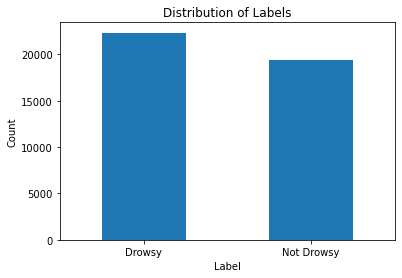

In [173]:
# Plot the distribution of labels
df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Drowsy', 'Not Drowsy'], rotation=0)
plt.show()

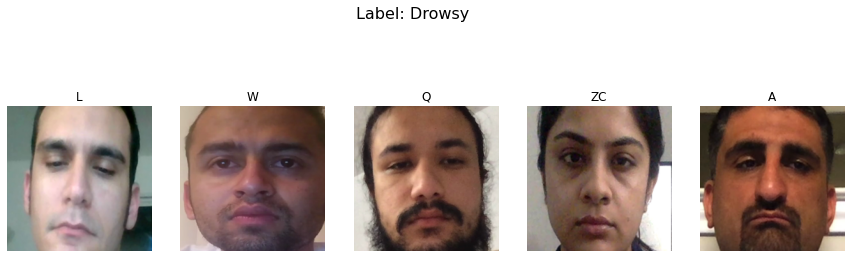

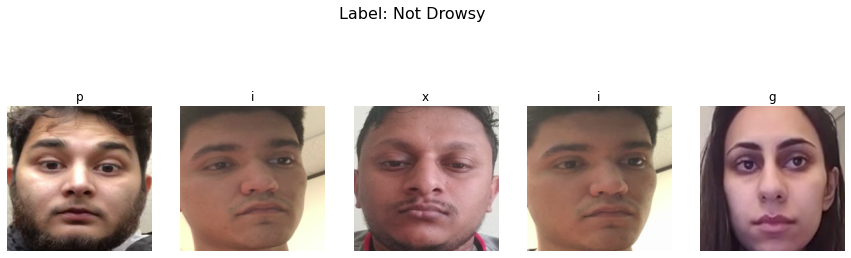

In [174]:
def display_sample_images(df, num_samples=5):
    """
    Displays 'num_samples' images for each unique label in the DataFrame,
    with the title of each image set to the person's name and label as 'Drowsy' or 'Not Drowsy'.

    :param df: DataFrame with columns 'images', 'label', and 'person'.
    :param num_samples: Number of samples to display for each label.
    """
    label_names = {0: 'Drowsy', 1: 'Not Drowsy'}
    labels = df['label'].unique()

    for label in labels:
        # Filter the dataframe for the current label
        df_label = df[df['label'] == label]

        # Randomly select 'num_samples' images
        sample_images = df_label.sample(n=num_samples)

        # Plot each sample image
        plt.figure(figsize=(15, 5))
        plt.suptitle(f"Label: {label_names[label]}", fontsize=16)
        for i, (image_path, person_name) in enumerate(zip(sample_images['images'], sample_images['person']), 1):
            img = Image.open(image_path)
            plt.subplot(1, num_samples, i)
            plt.imshow(img)
            plt.axis('off')
            plt.title(person_name)
        plt.show()

# Call the function with your DataFrame
display_sample_images(df)

#### Dataset distribution : Images per Person

In [175]:
#number of images of ALL persons of the dataset
result = df.groupby("person").size()
print(result)


person
A     1411
B      315
C      335
D      179
E      962
F      415
G      499
H      508
I     1095
J      474
K      630
L      732
M      777
N     1156
O     1097
P      963
Q      562
R      204
S      487
T      933
U      420
V      653
W     1162
X     1749
Y     1112
ZA     621
ZB    1551
ZC    1346
a     1252
b      409
c      400
d     1005
e     1000
g      109
h      571
i     1045
j      717
k      538
l      381
m      473
n      957
o      671
p      190
q      521
r      522
s      457
u      510
v     1002
w      493
x     1143
y     1500
za    1054
zb    1237
zc    1288
dtype: int64


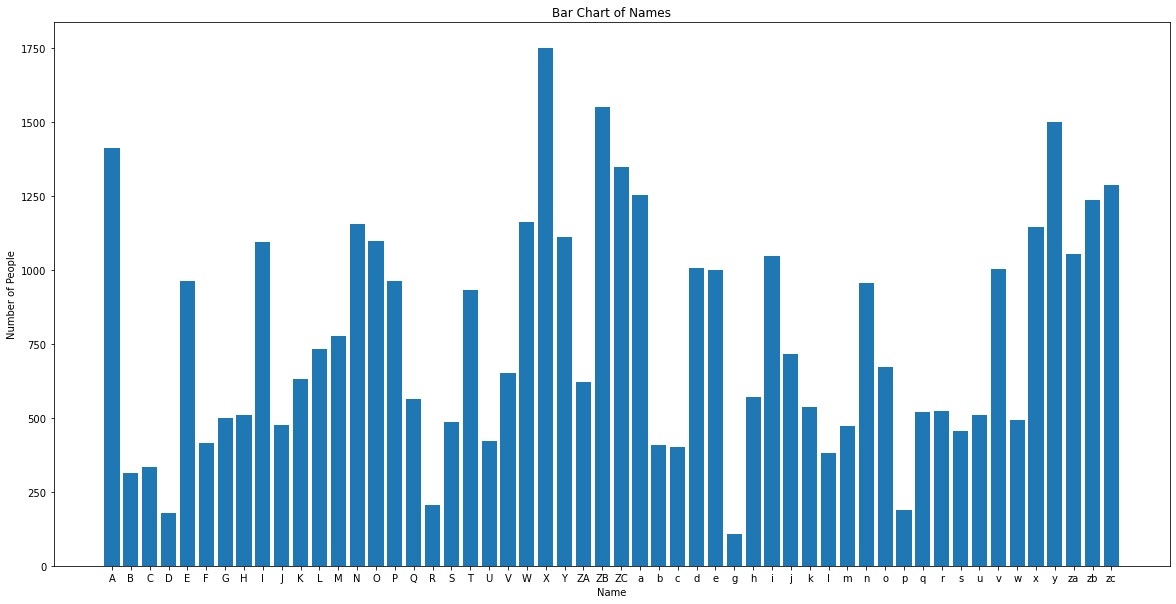

In [176]:
#plotting barchart of All persons
plt.figure(figsize=(20,10))
plt.bar(result.index, result.values, )
plt.xlabel('Name')
plt.ylabel('Number of People')
plt.title('Bar Chart of Names')
plt.show()

#### Cross-tabulation of Labels and Persons

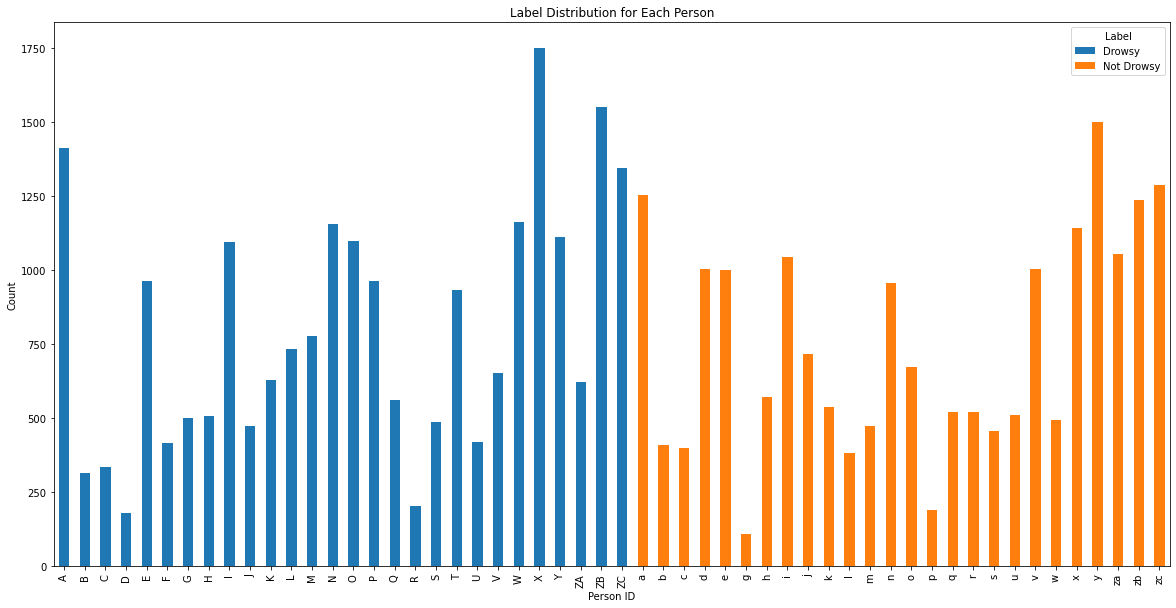

In [177]:
# Create a cross-tabulation of persons and labels
pd.crosstab(df['person'], df['label']).plot(kind='bar', stacked=True, figsize=(20, 10))
plt.title('Label Distribution for Each Person')
plt.xlabel('Person ID')
plt.ylabel('Count')
plt.legend(title='Label', labels=['Drowsy', 'Not Drowsy'])
plt.show()


### Train and Test Dataset Split

In [178]:
#nparray with all other persons (except of E, G, S) gets split into train and test dataset
trainW, testW = train_test_split(comp_data, test_size=0.2, random_state=1234)
print('trainW')
print(trainW.shape)

print('testW')
print(testW.shape)

#train dataset
train = trainW

#test dataset is a combination of the takeout of person E, G, S and the part that was split to test via train_test_split
test = np.concatenate((testTO, testW))

print('test')
print(test.shape)
     

trainW
(28867, 2)
testW
(7217, 2)
test
(12926, 2)


In [179]:
#basic methods of Dataset class need to be overwritten
class DDDdataset(Dataset):
  def __init__(self, image_paths, image_labels, transform):
    super().__init__()
    self.paths = image_paths
    self.labels = image_labels
    self.len = len(self.paths)
    self.transform = transform
  
  def __len__(self): return self.len
  
  def __getitem__(self, index):
    path = self.paths[index]
    label = self.labels[index]
    target_tensor=torch.from_numpy(np.array(label,dtype=np.int16))
    image = cv2.imread(path,cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert the NumPy array to a PIL Image
    image = Image.fromarray(image)

    # Apply transformations
    if self.transform:
      image = self.transform(image)
    
    return (image, target_tensor, path)

## Standardisation

In [180]:
#TRANSFORMATION, TRAIN DATASET AND LOADER FOR THE CALCULATION OF MEAN AND STD FOR EVERY CHANNEL

# Transformation for the calculation of mean and std for the train dataset
transformationCalc = transforms.Compose([
    transforms.ToTensor()
])

# Train dataset and loader for the calculation of mean and std
trainDatasetCalc = DDDdataset(train[:,0], train[:,-1], transformationCalc)
loaderCalc = DataLoader(trainDatasetCalc, batch_size=128, shuffle=True, num_workers=8)

### Mean and STD calculation


In [181]:
# Initialize variables to accumulate sums and squared sums
sum_rgb = torch.tensor([0.0, 0.0, 0.0])
sum_squared_rgb = torch.tensor([0.0, 0.0, 0.0])
total_pixels = 0

# Calculate sums and squared sums
for batch in loaderCalc:
    images = batch[0]
    batch_size = images.size(0)
    sum_rgb += images.sum(dim=[0, 2, 3])
    sum_squared_rgb += (images ** 2).sum(dim=[0, 2, 3])
    total_pixels += batch_size * images.size(2) * images.size(3)

# Calculate mean and std for R, G, B
mean_rgb = sum_rgb / total_pixels
std_rgb = (sum_squared_rgb / total_pixels - mean_rgb ** 2).sqrt()

# Print results
print("Mean (R, G, B):", mean_rgb)
print("Std (R, G, B):", std_rgb)

Mean (R, G, B): tensor([0.5068, 0.3878, 0.3420])
Std (R, G, B): tensor([0.2499, 0.2321, 0.2200])


## Model Building

### Train and Test DataLoaders

In [182]:
# Transformation for model training and testing with calculated mean and std
transformation = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(10),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_rgb.tolist(), std=std_rgb.tolist())
])

# Datasets and dataloaders for model training and testing
trainDataset = DDDdataset(train[:,0], train[:,-1], transformation)
testDataset = DDDdataset(test[:,0], test[:,-1], transformation)
trainDataLoader = DataLoader(trainDataset, batch_size=64, shuffle=True, num_workers=8)
testDataLoader = DataLoader(testDataset, batch_size=64, shuffle=True, num_workers=8)

### Model Architecture

In [183]:
#LAYERS OF THE MODEL

class CNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=(4,4), stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(10)
    self.conv2 = nn.Conv2d(in_channels=10, out_channels=15, kernel_size=(5,5), stride=2, padding=1)
    self.bn2 = nn.BatchNorm2d(15)
    self.conv3 = nn.Conv2d(in_channels=15, out_channels=20, kernel_size=(6,6), stride=2, padding=1)
    self.bn3 = nn.BatchNorm2d(20)
    self.conv4 = nn.Conv2d(in_channels=20, out_channels=25, kernel_size=(3,3), stride=1, padding=1)
    self.bn4 = nn.BatchNorm2d(25)

    self.fc1 = nn.Linear(in_features=25*3*3, out_features=45)
    self.bn5 = nn.BatchNorm1d(45)
    self.fc2 = nn.Linear(in_features=45, out_features=20)
    self.bn6 = nn.BatchNorm1d(20)
    self.fc3 = nn.Linear(in_features=20, out_features=2)

  def forward(self, X):

    X = F.relu(self.bn1(self.conv1(X)))
    X = F.max_pool2d(X, 2)
    X = F.relu(self.bn2(self.conv2(X)))
    X = F.max_pool2d(X, 2)
    X = F.relu(self.bn3(self.conv3(X)))
    X = F.max_pool2d(X, 3, stride=2)
    X = F.relu(self.bn4(self.conv4(X)))
    X = F.max_pool2d(X, 2)

    X = X.view(X.shape[0], -1)
    X = F.relu(self.bn5(self.fc1(X)))
    X = F.relu(self.bn6(self.fc2(X)))
    X = self.fc3(X)

    return X

    # Total number of trainable Parameters = 31002

In [184]:
#MODEL TRAINING AND TESTING

import time

#basic settings
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters
early_stopping_patience = 2
early_stopping_delta = 0.001
best_loss = float('inf')
epochs_without_improvement = 0

losses = []         # for plotting 
accuracies = []      # for plotting
test_losses = []    # for plotting
test_accuracies = []   # for plotting

f1score_list = []
f1score_test_list = []


#for the analysis of the wrong classifications
pathsOfWrongClassifications = []
rowsOfWrongClassifications = None
correctLabel = []
epochOfWrongClassification = []

start = time.time()

#model training and testing process
epoch = 0
while True:
  model.train()
  train_preds, test_preds_list, train_class, test_class = [], [], [], []
  epoch_loss, epoch_accuracy = 0, 0

  # Model training  
  for (X, y, path) in trainDataLoader:
    X = X.to(device) #torch.as_tensor(X)
    y = y.to(device) #torch.as_tensor(y)
    
    train_class.extend(y.cpu().tolist())   #adds all the true labels in the batches in each epoch to the list
    
    predictions = model(X)
    
    
    pred_class = predictions.argmax(dim=1)         ##finding predicted class labels for f1score
    train_preds.extend(pred_class.cpu().tolist())    #adds all the predicted labels in the batches in each epoch to the list
    
    
    
    loss = loss_func(predictions, y.long())

    #adaption of the neural network
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #
    accuracy = ((predictions.argmax(dim=1) == y).float().mean())
    
    #epoch_accuracy and epoch_loss as it is being plotted cannot be tensor on cuda or have requiresgrad=True 
    epoch_accuracy += accuracy.cpu().detach().numpy()   
    epoch_loss += loss.cpu().detach().numpy()
  
  #total epoch_accuracy and epoch_loss calculation
  epoch_accuracy = epoch_accuracy/len(trainDataLoader)
  accuracies.append(epoch_accuracy)
  epoch_loss = epoch_loss / len(trainDataLoader)
  losses.append(epoch_loss)
  
  # calculating f1_score in train
  f1score = f1_score(train_preds, train_class, average = 'weighted')
  f1score_list.append(f1score)
    
  print("\n --- Epoch: {}, train loss: {:.4f}, train acc: {:.4f}, f1 score: {:.4f},  time: {}".format(epoch, epoch_loss, epoch_accuracy, f1score, time.time() - start))
  #-------model training-------
  
  
  #---model testing---
  model.eval() #sets the model in evaluation mode
  
  #with disabled gradient calculation
  with torch.no_grad():
    test_epoch_loss = 0
    test_epoch_accuracy = 0

    for test_X, test_y, path in testDataLoader:

      test_X = test_X.to(device)
      test_y = test_y.to(device)
        
      test_class.extend(test_y.cpu().tolist())   #adds all the true labels in the batches in each epoch to the list

      test_preds = model(test_X)
      
      test_pred_class = test_preds.argmax(dim=1)    #finding predicted class labels for f1score  
      test_preds_list.extend(test_pred_class.cpu().tolist())   #adds all the predicted labels in the batches in each epoch to the list
    
    
      test_loss = loss_func(test_preds, test_y.long())
      
      
        
      test_epoch_loss += test_loss.cpu().numpy()            
      test_accuracy = ((test_preds.argmax(dim=1) == test_y).float().mean())
      test_epoch_accuracy += test_accuracy.cpu().numpy()

      #if test prediction is wrong save the path of the image that has been classified wrong
      for index, row in enumerate(test_preds):
        if row.argmax(dim=0) != test_y[index]:
          pathsOfWrongClassifications.append(path[index])
          if rowsOfWrongClassifications is None:
            row = row.cpu()
            rowsOfWrongClassifications = row
          else:
            row = row.cpu()
            rowsOfWrongClassifications = np.vstack([rowsOfWrongClassifications, row])
          correctLabel.append(test_y[index].item())
          epochOfWrongClassification.append(epoch)

    #total test_epoch_accuracy and test_epoch_loss calculation
    
    test_epoch_accuracy = test_epoch_accuracy/len(testDataLoader)
    test_accuracies.append(test_epoch_accuracy)   #for plotting
    
    test_epoch_loss = test_epoch_loss / len(testDataLoader)
    test_losses.append(test_epoch_loss)           #for plotting
    
    f1score_test = f1_score(test_preds_list, test_class, average = 'weighted')
    f1score_test_list.append(f1score_test) 

  # Early stopping check
  if test_epoch_loss < best_loss - early_stopping_delta:
    best_loss = test_epoch_loss
    epochs_without_improvement = 0
    # Save the model checkpoint if desired
    # torch.save(model.state_dict(), 'best_model_checkpoint.pth')
  else:
    epochs_without_improvement += 1

  if epochs_without_improvement >= early_stopping_patience:
    print("Stopping early at epoch {} due to no improvement in validation loss.".format(epoch))
    break

  print("Epoch: {}, test loss: {:.4f}, test acc: {:.4f}, f1score: {:.4f}, time: {}\n".format(epoch, test_epoch_loss, test_epoch_accuracy, f1score_test_list[-1], time.time() - start))

  epoch += 1  # Increment the epoch counter

  model.train(mode=True) #sets the model back in training mode


 --- Epoch: 0, train loss: 0.0762, train acc: 0.9900, f1 score: 0.9914,  time: 26.71131706237793
Epoch: 0, test loss: 0.2468, test acc: 0.8941, f1score: 0.8936, time: 39.49308490753174


 --- Epoch: 1, train loss: 0.0136, train acc: 0.9972, f1 score: 0.9972,  time: 66.09097671508789
Epoch: 1, test loss: 0.0945, test acc: 0.9703, f1score: 0.9703, time: 78.58966207504272


 --- Epoch: 2, train loss: 0.0026, train acc: 0.9997, f1 score: 0.9997,  time: 105.6142225265503
Epoch: 2, test loss: 0.1992, test acc: 0.9291, f1score: 0.9291, time: 117.46091961860657


 --- Epoch: 3, train loss: 0.0010, train acc: 1.0000, f1 score: 1.0000,  time: 144.15769457817078
Stopping early at epoch 3 due to no improvement in validation loss.


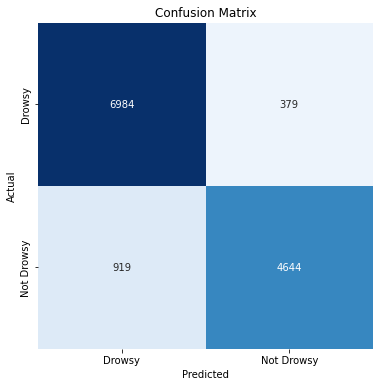

Classification Report:
----------------------
               precision    recall  f1-score   support

      Drowsy       0.88      0.95      0.91      7363
  Not Drowsy       0.92      0.83      0.88      5563

    accuracy                           0.90     12926
   macro avg       0.90      0.89      0.90     12926
weighted avg       0.90      0.90      0.90     12926



In [185]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


# Calculate the confusion matrix
cm = confusion_matrix(test_class, test_preds_list)

# Generate a classification report
clr = classification_report(test_class, test_preds_list, target_names=['Drowsy', 'Not Drowsy'])

# Output the results
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=['Drowsy', 'Not Drowsy'])
plt.yticks(ticks=[0.5, 1.5], labels=['Drowsy', 'Not Drowsy'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)


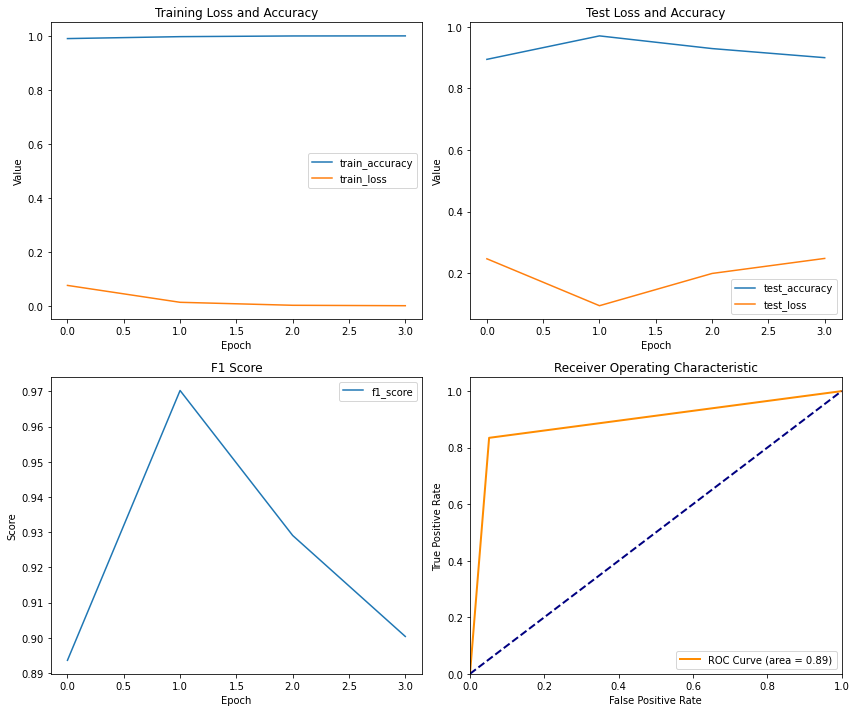

In [186]:
from sklearn.metrics import roc_curve, auc

# Set up the figure and axes for a 2x2 grid of plots
plt.figure(figsize=(12, 10))

# Plot 1: Training Loss and Accuracy
plt.subplot(2, 2, 1)  # First row, first column
plt.plot(accuracies, label='train_accuracy')
plt.plot(losses, label='train_loss')
plt.legend()
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')

# Plot 2: Test Loss and Accuracy
plt.subplot(2, 2, 2)  # First row, second column
plt.plot(test_accuracies, label='test_accuracy')
plt.plot(test_losses, label='test_loss')
plt.legend()
plt.title('Test Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')

# Plot 3: F1 Score
plt.subplot(2, 2, 3)  # Second row, first column
plt.plot(f1score_test_list, label='f1_score')
plt.legend()
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')

# Plot 4: ROC Curve
plt.subplot(2, 2, 4)  # Second row, second column
fpr, tpr, thresholds = roc_curve(test_class, test_preds_list)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Show the plots
plt.tight_layout()
plt.show()


In [187]:
# Analyze the data for the last epoch
last_epoch = epoch

# Extract the person ID out of the stored image paths
personID = [pathStr[pathStr.rfind('/')+1:-8] for pathStr in pathsOfWrongClassifications]

# Create a dataframe from all wrong classified images in the test dataset
dfWrong = pd.DataFrame({
    'testEpochNo': epochOfWrongClassification,
    'personID': personID,
    'imagepath': pathsOfWrongClassifications,
    'correctLabel': correctLabel,
    'outputValueLabel0': rowsOfWrongClassifications[:, 0],
    'outputValueLabel1': rowsOfWrongClassifications[:, 1]
})
dfOfEpoch = dfWrong[dfWrong['testEpochNo'] == last_epoch]

# Group by personID and count wrong classifications
wrong_count = dfOfEpoch.groupby('personID').size()

# Create a DataFrame for the analysis
analysis_df = pd.DataFrame({
    'personID': wrong_count.index,
    'WrongCount': wrong_count.values
})

# Count the total number of occurrences for each person and convert it to DataFrame
total_count = df.groupby('person').size().reset_index(name='TotalCount')

# Merge analysis_df with total_count
analysis_df = pd.merge(analysis_df, total_count, left_on='personID', right_on='person')

# Calculate the percentage of wrong classifications
analysis_df['Percentage'] = (analysis_df['WrongCount'] / analysis_df['TotalCount']) * 100

# Sort the DataFrame in descending order of the likelihood of being wrongly classified
analysis_df = analysis_df.sort_values(by='Percentage', ascending=False)

# Print the results
print("Analysis of Persons Likely to be Wrongly Classified in the Last Epoch:")
print(analysis_df[['personID', 'WrongCount', 'TotalCount', 'Percentage']])


Analysis of Persons Likely to be Wrongly Classified in the Last Epoch:
  personID  WrongCount  TotalCount  Percentage
6        p         157         190   82.631579
7       zb         685        1237   55.375909
3       ZB         267        1551   17.214700
5        o          76         671   11.326379
2        P         106         963   11.007269
1        O           5        1097    0.455789
4        n           1         957    0.104493
0        E           1         962    0.103950


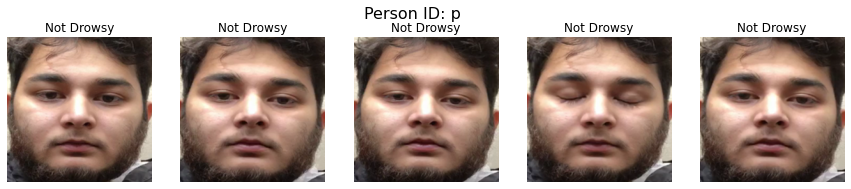

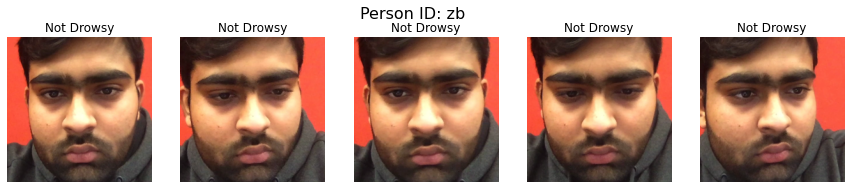

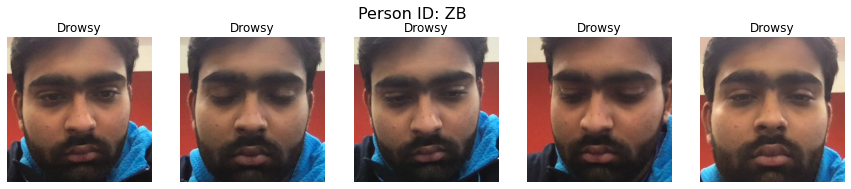

In [190]:
import matplotlib.pyplot as plt
from PIL import Image

# Assuming df contains columns 'images', 'label', and 'person'
# Define the persons with a high likelihood of wrong classification
high_risk_persons = ['p', 'zb', 'ZB']

# Loop through each person and display 5 images
for person in high_risk_persons:
    # Filter the DataFrame for the current person
    df_person = df[df['person'] == person]

    # Randomly sample 5 images from this person
    sample_images = df_person.sample(n=5)

    # Plot each image with its label
    plt.figure(figsize=(15, 3))
    plt.suptitle(f"Person ID: {person}", fontsize=16)
    for i, (image_path, label) in enumerate(zip(sample_images['images'], sample_images['label']), 1):
        img = Image.open(image_path)
        plt.subplot(1, 5, i)
        plt.imshow(img)
        plt.axis('off')
        title = "Drowsy" if label == 0 else "Not Drowsy"
        plt.title(title)
    plt.show()
